In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
params = dict()
params['DATA_DIR']='.'
params['IMG_DIR'] = '../../../data/images'
params['GPU_ID']='0' 
params['EMBEDDDIM'] = (100,200)
params['DATAFOLDS'] = 5
params['CUDA']=False 
params['WORKERS']=4
params['Z_DIM']=100
params['LR_DECAY_EPOCH']=20
params['STAGE']=1
params['IMGSIZE1']=64
params['IMGSIZE2']=255
params['MAX_EPOCH']=2
params['BATCH_SIZE']=128
params['SNAPSHOT_INTERVAL']=1
params['DISCRIMINATOR_LR']=0.0002
params['GENERATOR_LR']=0.0002
params['DF_DIM']=96
params['GF_DIM']=192
params['CONDITION_DIM'] = 128
params['DIMENSION']=1024
params['R_NUM'] = 4
params['STAGE1_G']='../output/coco_stageI/Model/netG_epoch_120.pth'
args= params

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

# Conditional Augmentation and Embedding Representation

In [4]:
class T2O(nn.Module):
    def __init__(self):
        '''
            The word embeddings from the Word2Vec Model are of a 
            constant dimension, 100x200. This class is to convert 
            the 2D representation to 1D, so as to pass it through 
            rest of the model.
        '''

        super(T2O,self).__init__()
        self.in_channels =  args['EMBEDDDIM'][0] # number of channels for 1D conv.
        self.in_features = (args['EMBEDDDIM'][1]-10+1) #Calculating the inputs for the linear layer.
        self.model = nn.Sequential(
            nn.Conv1d(self.in_channels,32,10),
            nn.Flatten(),
            nn.Linear(32*self.in_features,1024),
            nn.ReLU()
        )

    def forward(self,embedding):
        return self.model(embedding)

In [5]:
class CA_NET(nn.Module):
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = args['DIMENSION']
        self.c_dim = args['CONDITION_DIM']
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding, audio_embedding):
            x = self.relu(self.fc(text_embedding))
            y = self.relu(self.fc(audio_embedding))
            mu = torch.cat((x[:, :self.c_dim],y[:, :self.c_dim]),1)
            logvar = torch.cat((x[:, self.c_dim:],y[:, self.c_dim:]),1)
            return mu, logvar

    def reparametrize(self, mu, logvar):
            std = logvar.mul(0.5).exp_()
            eps = torch.Tensor(std.size()).normal_()
            return eps.mul(std).add_(mu)
    
    def forward(self, text_embedding, audio_embedding):
            mu, logvar = self.encode(text_embedding,audio_embedding)
            c_code = self.reparametrize(mu, logvar)
            return c_code, mu, logvar

# Stage 1 GAN

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            conv3x3(in_planes, out_planes),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )
    return block


class STAGE1_G(nn.Module):
    def __init__(self):
        super(STAGE1_G, self).__init__()
        self.gf_dim = args['GF_DIM'] * 8
        self.ef_dim = args['CONDITION_DIM'] * 2
        self.z_dim = args['Z_DIM']
        self.define_module()


    def define_module(self):
            # twice, once for audio vector and once for the text
            ninput = self.z_dim + self.ef_dim 
            ngf = self.gf_dim
            # extracts a vector of 1D from 2D
            self.t2o = T2O()
            # conditional aug network
            self.ca_net = CA_NET()
            # ngf x 4 x 4
            self.fc = nn.Sequential(
                nn.Linear(ninput, ngf * 4 * 4, bias=False),
                nn.BatchNorm1d(ngf * 4 * 4),
                nn.ReLU(True),
            )
            # ngf x 4 x 4 -> ngf/2 x 8 x 8
            self.upsample1 = upBlock(ngf, ngf // 2)
            # ngf/4 x 16 x 16
            self.upsample2 = upBlock(ngf // 2, ngf // 4)
            # ngf/8 x 32 x 32
            self.upsample3 = upBlock(ngf // 4, ngf // 8)
            # ngf/16 x 64 x 64
            self.upsample4 = upBlock(ngf // 8, ngf // 16)
            # 3 x 64 x 64
            self.img = nn.Sequential(
                conv3x3(ngf // 16, 3),
                nn.Tanh())
    
    def forward(self, text_embedding, audio_embedding, noise):
            self.fc.train()
            # 2d to 1d vector
            t_e = self.t2o(text_embedding)
            a_e = self.t2o(audio_embedding)
            # conditional augmentation
            c_code, mu, logvar = self.ca_net(t_e,a_e)
            z_c_code = torch.cat((noise, c_code), 1)
            # linear and upsampling layers
            h_code = self.fc(z_c_code)
            h_code = h_code.view(-1, self.gf_dim, 4, 4)
            h_code = self.upsample1(h_code)
            h_code = self.upsample2(h_code)
            h_code = self.upsample3(h_code)
            h_code = self.upsample4(h_code)
            # state size 3 x 64 x 64
            # image generation
            fake_img = self.img(h_code)
            return None, fake_img, mu, logvar

    def eval(self, text_embedding, audio_embedding, noise):
            self.fc.eval()
            # 2d to 1d vector
            t_e = self.t2o(text_embedding)
            a_e = self.t2o(audio_embedding)
            # conditional augmentation
            c_code, mu, logvar = self.ca_net(t_e,a_e)
            z_c_code = torch.cat((noise, c_code), 1)
            # linear and upsampling layers
            h_code = self.fc(z_c_code)
            h_code = h_code.view(-1, self.gf_dim, 4, 4)
            h_code = self.upsample1(h_code)
            h_code = self.upsample2(h_code)
            h_code = self.upsample3(h_code)
            h_code = self.upsample4(h_code)
            # state size 3 x 64 x 64
            # image generation
            fake_img = self.img(h_code)
            return None, fake_img, mu, logvar


In [7]:
# instantiate the generator
netG = STAGE1_G()
# apply the weights_init fuction
netG.apply(weights_init)
# print the generator network
print(netG)

STAGE1_G(
  (t2o): T2O(
    (model): Sequential(
      (0): Conv1d(100, 32, kernel_size=(10,), stride=(1,))
      (1): Flatten()
      (2): Linear(in_features=6112, out_features=1024, bias=True)
      (3): ReLU()
    )
  )
  (ca_net): CA_NET(
    (fc): Linear(in_features=1024, out_features=256, bias=True)
    (relu): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=356, out_features=24576, bias=False)
    (1): BatchNorm1d(24576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upsample1): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(1536, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (upsample2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(768, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2

In [23]:
class STAGE1_D(nn.Module):
    def __init__(self):
        super(STAGE1_D, self).__init__()
        self.df_dim = args['DF_DIM']
        self.ef_dim = args['CONDITION_DIM'] * 2
        self.define_module()

    def define_module(self):
        
            ndf, nef = self.df_dim, self.ef_dim
            self.encode_img = nn.Sequential(
                nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ndf) x 32 x 32
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                # state size (ndf*2) x 16 x 16
                nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                # state size (ndf*4) x 8 x 8
                nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 8),
                # state size (ndf * 8) x 4 x 4)
                nn.LeakyReLU(0.2, inplace=True)
            )
            self.outlogits = nn.Sequential(
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())
            # self.get_cond_logits = D_GET_LOGITS(ndf, nef)
            # self.get_uncond_logits = None

    def forward(self, image):
            self.encode_img.train()
            self.outlogits.train()
            
            img_embedding = self.encode_img(image)
            return self.outlogits(img_embedding).flatten()

    def eval(self, image):
        self.encode_img.eval()
        img_embedding = self.encode_img(image)
        return self.outlogits(img_embedding).flatten()


In [24]:
# instantiate the generator
netD = STAGE1_D()
# apply the weights_init fuction
netD.apply(weights_init)
# print the generator network
print(netD)

STAGE1_D(
  (encode_img): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (outlogits): Sequential(
    (0): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [25]:
t2o = T2O()
ca = CA_NET()
sample = torch.rand(2,100,200)
noise = torch.rand(2,100)

In [26]:
_, img, mu, sigma = netG(sample,sample,noise)
img.shape

torch.Size([2, 3, 64, 64])

In [27]:
netD(img).shape

torch.Size([2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 64, 64])

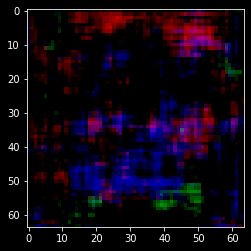

In [28]:
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(img[0].detach().numpy(),0,2))
img.shape

# Stage 2 GAN

In [29]:
class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

In [30]:
class STAGE2_G(nn.Module):
    def __init__(self, STAGE1_G):
        super(STAGE2_G, self).__init__()
        self.gf_dim = args['GF_DIM']
        self.ef_dim = args['CONDITION_DIM']*2
        self.z_dim = args['Z_DIM']
        self.STAGE1_G = STAGE1_G
        # fix parameters of stageI GAN
        for param in self.STAGE1_G.parameters():
            param.requires_grad = False
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(args['R_NUM']):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        # extracts a vector of 1D from 2D
        self.t2o = T2O()
        # conditional aug network
        self.ca_net = CA_NET()
        # --> 4ngf x 16 x 16
        self.encoder = nn.Sequential(
            conv3x3(3, ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.hr_joint = nn.Sequential(
            conv3x3(self.ef_dim + ngf * 4, ngf * 4),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.residual = self._make_layer(ResBlock, ngf * 4)
        # --> 2ngf x 32 x 32
        self.upsample1 = upBlock(ngf * 4, ngf * 2)
        # --> ngf x 64 x 64
        self.upsample2 = upBlock(ngf * 2, ngf)
        # --> ngf // 2 x 128 x 128
        self.upsample3 = upBlock(ngf, ngf // 2)
        # --> ngf // 4 x 256 x 256
        self.upsample4 = upBlock(ngf // 2, ngf // 4)
        # --> 3 x 256 x 256
        self.img = nn.Sequential(
            conv3x3(ngf // 4, 3),
            nn.Tanh())

    def forward(self, text_embedding, audio_embedding, noise):
        # setting all the sequential models to training
        self.encoder.train()
        self.hr_joint.train()
        self.residual.train()
        _, stage1_img, _, _ = self.STAGE1_G(text_embedding, audio_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        # 2d to 1d vector
        t_e = self.t2o(text_embedding)
        a_e = self.t2o(audio_embedding)
        # conditional augmentation
        c_code, mu, logvar = self.ca_net(t_e,a_e)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar
        
    def eval(self, text_embedding, audio_embedding, noise):
        # setting all the sequential models to evaluation
        self.encoder.eval()
        self.hr_joint.eval()
        self.residual.eval()
        _, stage1_img, _, _ = self.STAGE1_G.eval(text_embedding, audio_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        # 2d to 1d vector
        t_e = self.t2o(text_embedding)
        a_e = self.t2o(audio_embedding)
        # conditional augmentation
        c_code, mu, logvar = self.ca_net(t_e,a_e)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar


In [31]:
netG2 = STAGE2_G(netG)
netG2.apply(weights_init)
netG2

STAGE2_G(
  (STAGE1_G): STAGE1_G(
    (t2o): T2O(
      (model): Sequential(
        (0): Conv1d(100, 32, kernel_size=(10,), stride=(1,))
        (1): Flatten()
        (2): Linear(in_features=6112, out_features=1024, bias=True)
        (3): ReLU()
      )
    )
    (ca_net): CA_NET(
      (fc): Linear(in_features=1024, out_features=256, bias=True)
      (relu): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=356, out_features=24576, bias=False)
      (1): BatchNorm1d(24576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(1536, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(768

In [102]:
class STAGE2_D(nn.Module):
    def __init__(self):
        super(STAGE2_D, self).__init__()
        self.df_dim = args['DF_DIM']
        self.ef_dim = args['CONDITION_DIM'] * 2
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 128 * 128 * ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # 64 * 64 * ndf * 2
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # 32 * 32 * ndf * 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # 16 * 16 * ndf * 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),  # 8 * 8 * ndf * 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),  # 4 * 4 * ndf * 32
            conv3x3(ndf * 32, ndf * 16),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),   # 4 * 4 * ndf * 16
            conv3x3(ndf * 16, ndf * 8),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)   # 4 * 4 * ndf * 8
        )
        self.outlogits = nn.Sequential(
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Flatten(),
            nn.Sigmoid())

        # self.get_cond_logits = D_GET_LOGITS(ndf, nef, bcondition=True)
        # self.get_uncond_logits = D_GET_LOGITS(ndf, nef, bcondition=False)

    def forward(self, image):
        self.encode_img.train()
        self.outlogits.train()

        img_embedding = self.encode_img(image)
        img = self.outlogits(img_embedding)
        return img

In [103]:
netD2 = STAGE2_D()
netD2

STAGE2_D(
  (encode_img): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(768, 1536, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1536, eps=1e-0

In [96]:
s1_img, f_img, mu, var = netG2.eval(sample,sample,noise)
f_img.shape

torch.Size([2, 3, 256, 256])

In [104]:
netD2(f_img)

tensor([[0.3341],
        [0.5998]], grad_fn=<SigmoidBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256])

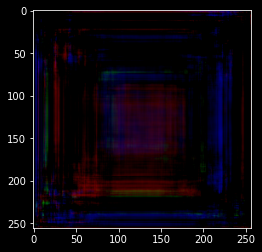

In [37]:
plt.imshow(np.moveaxis(f_img[0].detach().numpy(),0,2))
f_img.shape

# Dataloader

In [3]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import numpy as np
import torch
import pickle as p
import pandas as pd
import random
def load(path):
    with open(path, 'rb') as file:
        return p.load(file)
def save(obj, path):
    with open(path, 'wb') as file:
        p.dump(obj, file)

In [4]:
class DataSet(Dataset):

    def __init__(self):
        self.folds = args['DATAFOLDS']
        if args['STAGE'] == 2:
            self.imgdim = args['IMGSIZE1']
        else:
            self.imgdim = args['IMGSIZE2']
        self.transform = transforms.Compose([
            transforms.Resize(self.imgdim),
            transforms.ToTensor(),
        ])
        self.__load_embeddings(args['DATA_DIR'])
        self.__load_images(args['IMG_DIR'])

    def __len__(self):
        return len(self.text_embedding) * self.folds

    def __load_embeddings(self, path):
        self.text_embedding, self.text_labels = load(
            os.path.join(path, 'text_embeddings.p'))
        self.text_embedding, self.audio_labels = load(
            os.path.join(path, 'text_embeddings.p'))
        self.mapping = pd.read_csv(os.path.join(path, 'mapping.csv'),sep='\s*,\s*')
        self.mapping['id'] = self.mapping['id'].apply(str)#.set_index('id')

    def __load_images(self, path):
        classes = os.listdir(path)
        self.label_map = {cls.lower(): i for i, cls in enumerate(classes)}
        classes = [os.path.join(path, cls) for cls in classes]
        self.images = ([[os.path.join(cls, file) for file in os.listdir(
            cls) if file.endswith('.jpg') or file.endswith('.png')] for cls in classes])

    def __process_image(self, path):
        img = Image.open(path)
        return self.transform(img)

    def __getitem__(self, idx):
        '''
            for every embedding it returns 40% mismatched data
            and 60% matching data
        '''
        neg = False
        if idx % self.folds / self.folds >= 0.5:
            neg = True
        idx = idx // self.folds

        text = torch.tensor(self.text_embedding[idx])
        audio = torch.tensor(self.text_embedding[idx])

        
        id = self.text_labels[idx]
        genre = list(self.mapping[self.mapping['id'] == id].genre)[0].lower()
        genre_idx = self.label_map[genre]

        if neg:
            cls = random.choice(
                [i for i in range(len(self.label_map)) if i != genre_idx])
            img_idx = random.choice(range(len(self.images[cls])))
            label = 0
        else:
            cls = genre_idx
            img_idx = random.choice(range(len(self.images[cls])))
            label = 1

        img = self.__process_image(self.images[cls][img_idx])

        return text, audio, img, label

In [7]:
obj = ([np.random.rand(100,200) for i in range(100)],[str(i) for i in range(1,101)])
save(obj,'audio_embeddings.p')
save(obj,'text_embeddings.p')
x = pd.DataFrame([[str(i), random.choice(list(ds.label_map))] for i in range(1,101)],columns=['id','genre']).set_index('id')
x.to_csv('mapping.csv')

In [8]:
ds = DataSet()
dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=True,num_workers=4)

In [9]:
for i, data in enumerate(dl):
    text, audio, image, label = data
    break

In [10]:
from utils import train

In [11]:
train(dl, args)

0%|          | 0/2 [00:00<?, ?it/s]#######################
#   Running epoch:0...
#######################

  0%|          | 0/2 [00:03<?, ?it/s]


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat1' in call to _th_addmm_